# Gene exploration for mQTLs
1. Checking overlap in genes for sex-biased and marginal mQTLs in the delahaye data
2. Checking relative enrichment of these genes in housekeeping regions as defined from the HRT ATLAS human housekeeping genes set

In [1]:
library(data.table)
library(tidyverse)
library(UpSetR)
library(eulerr)
sex_specific < -fread("../data/sex_annotated_hits.txt.gz")
marginal < -fread("../data/marginal_annotated_hits.txt.gz")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



ERROR: Error in eval(expr, envir, enclos): object 'sex_specific' not found


[1] 440

[1] 2878

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


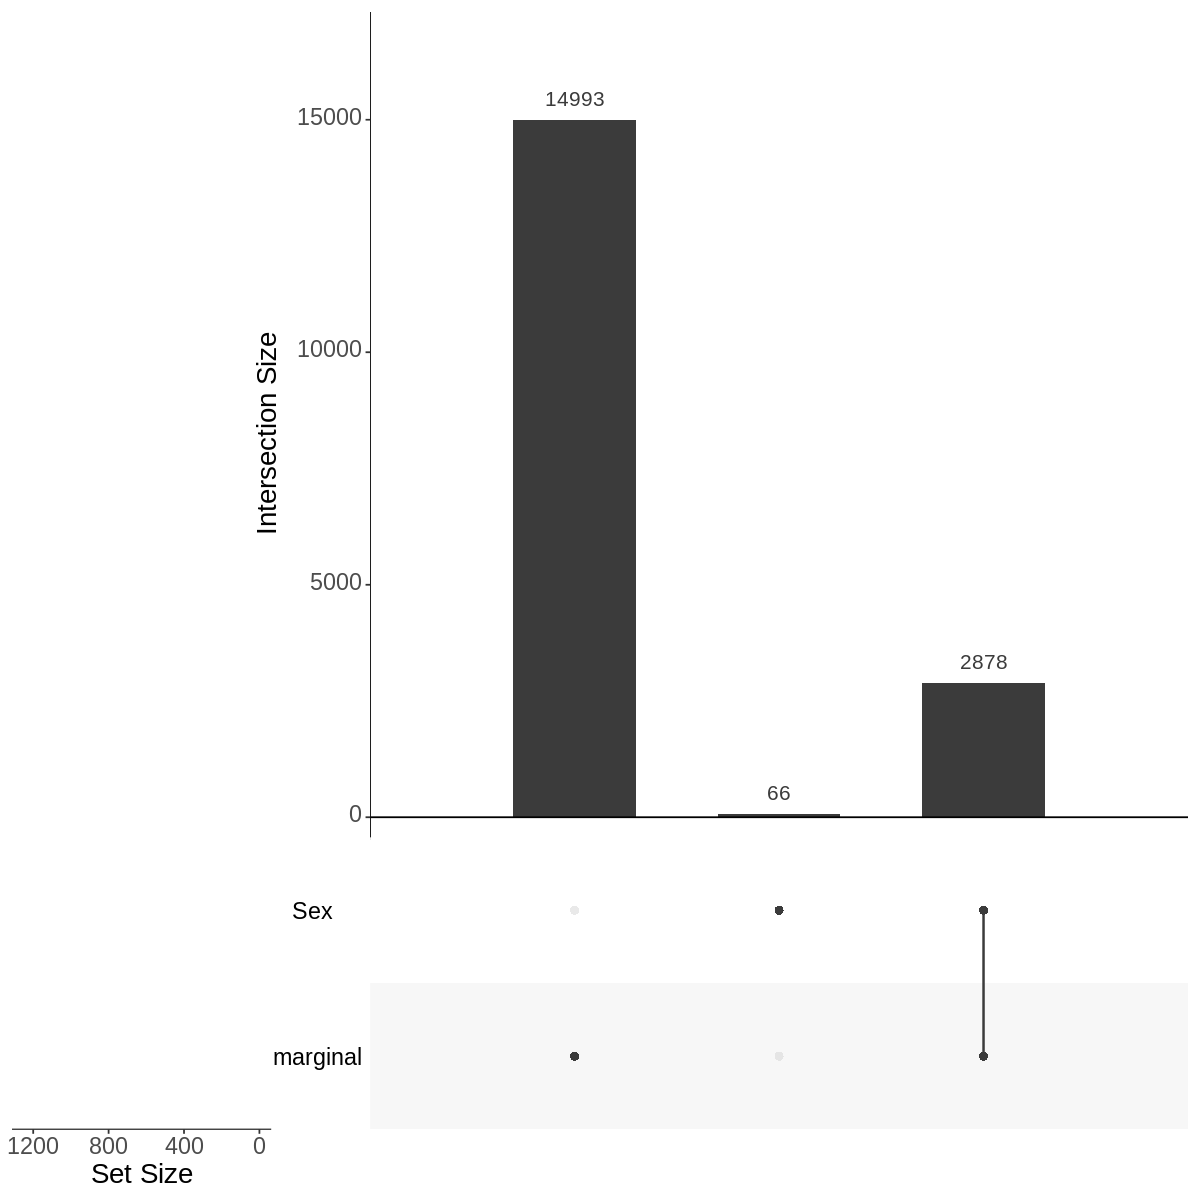

Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


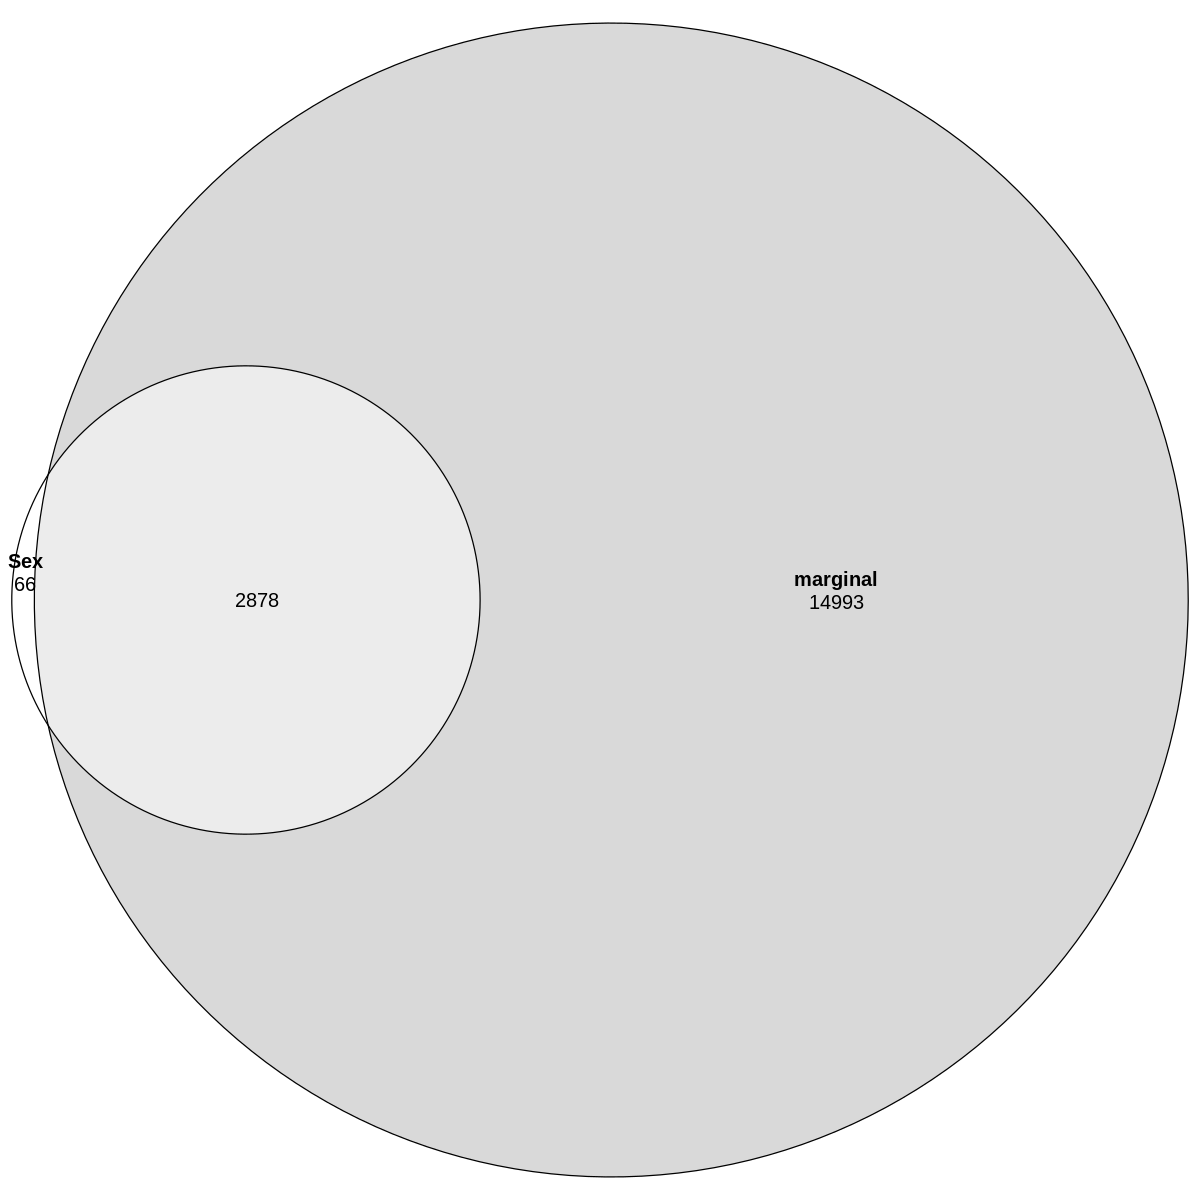

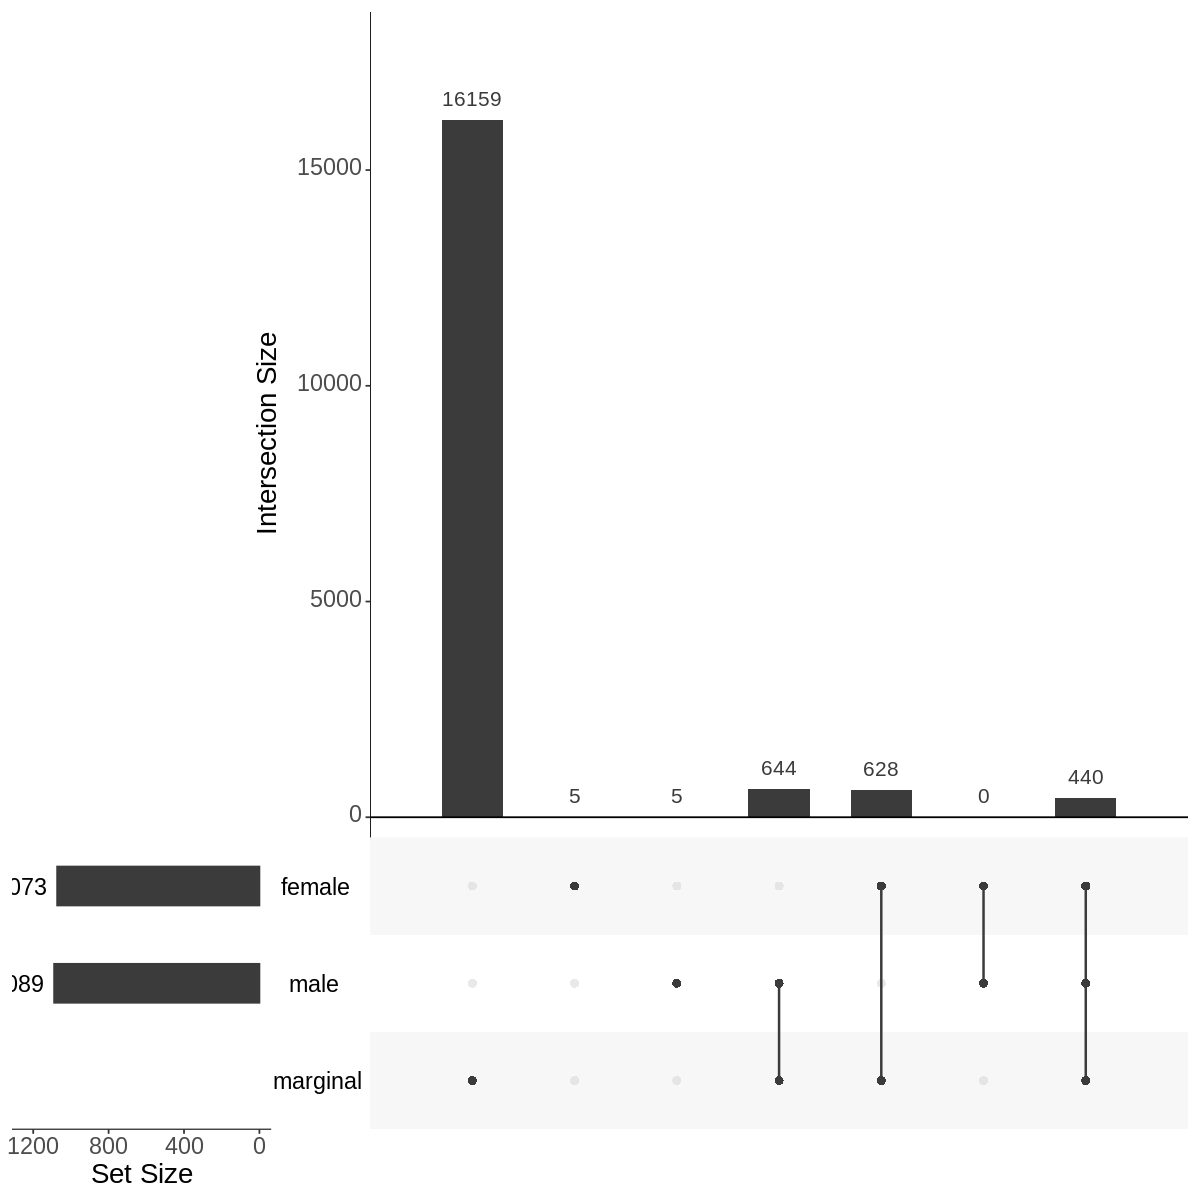

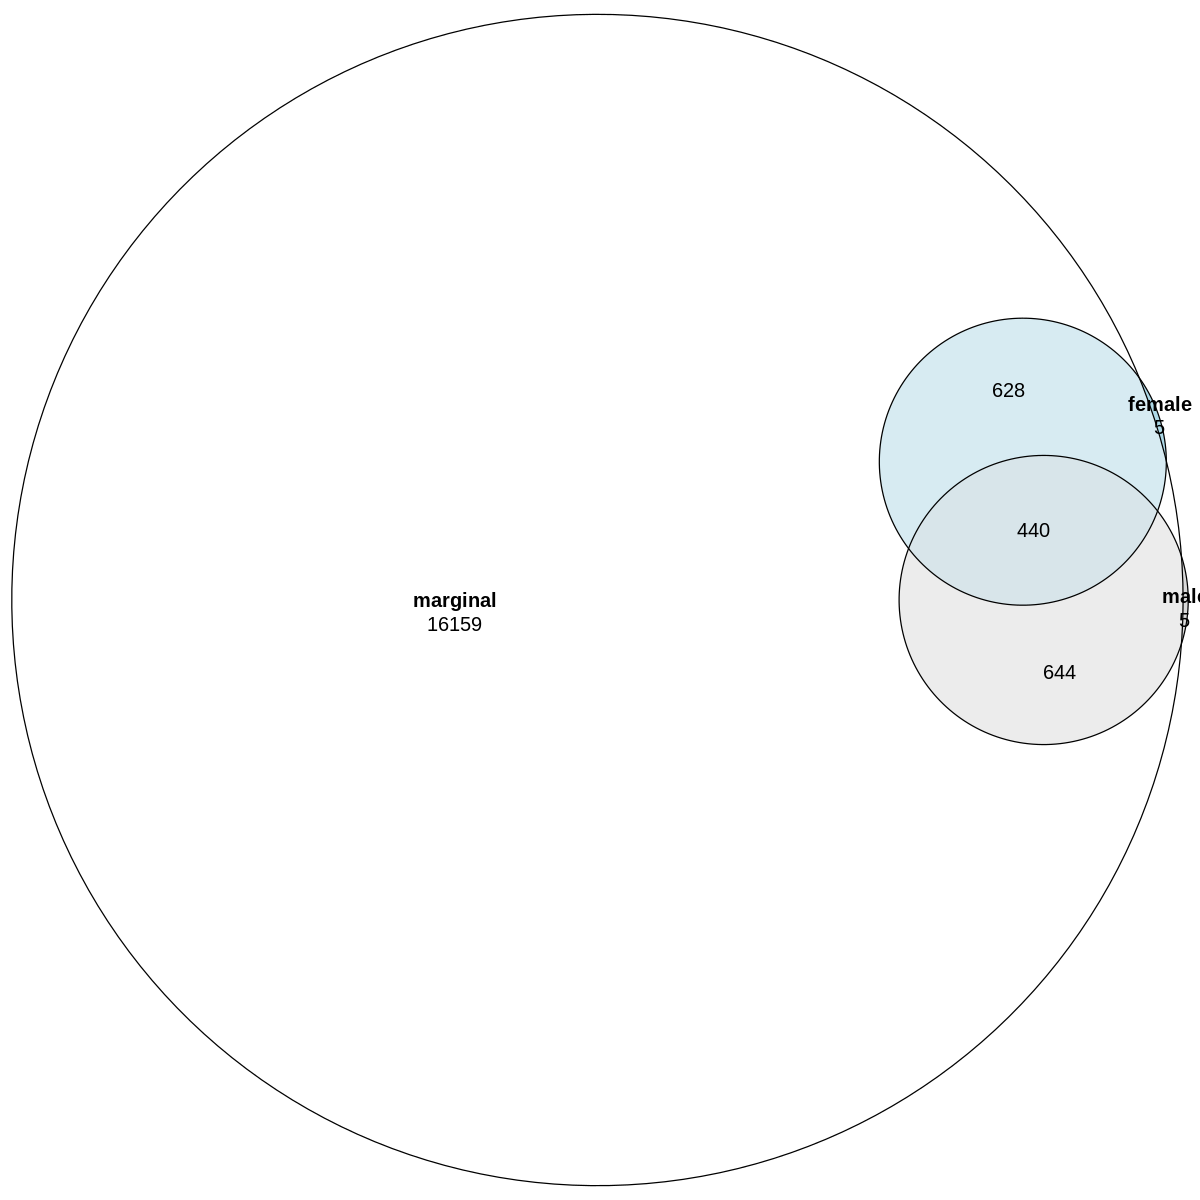

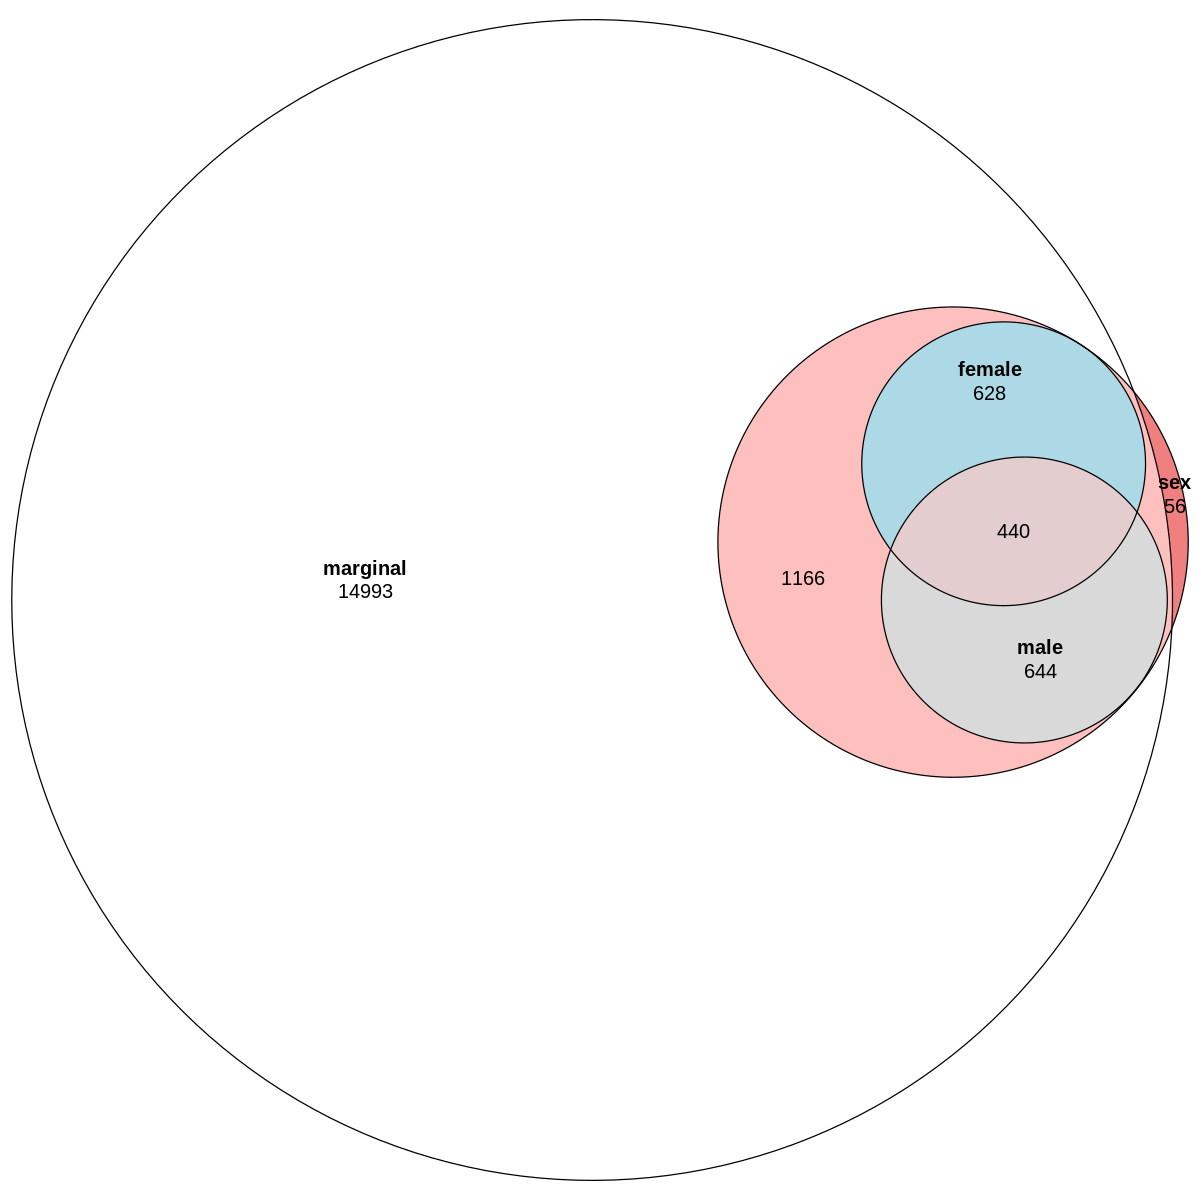

In [10]:
options(repr.plot.width=10, repr.plot.height=10)
sex_genes <- gsub(";.*","",sex_specific$UCSC_RefGene_Name)
male_genes <- gsub(";.*","",sex_specific[res_m < max(`p-value`)]$UCSC_RefGene_Name)
female_genes <- gsub(";.*","",sex_specific[res_f < max(`p-value`)]$UCSC_RefGene_Name)
marginal_genes <- gsub(";.*","",marginal$UCSC_RefGene_Name)

sex_genes <- unique(sex_genes[sex_genes != ""])
female_genes <-  unique(female_genes[female_genes != ""])
male_genes <-  unique(male_genes[male_genes != ""])
marginal_genes <-  unique(marginal_genes[marginal_genes != ""])


length(Reduce(function(a,b) intersect(a,b), list(sex_genes,male_genes,female_genes,marginal_genes)))
length(intersect(sex_genes,marginal_genes))
upset_data <- fromList(list(Sex=sex_genes, marginal=marginal_genes))    
upset(upset_data, group.by=c("degree"), empty.intersections="on", set_size.show = TRUE,text.scale = 2,set_size.scale_max = 1250)
plot(euler(upset_data),quantities=TRUE)

upset_data_sex <- fromList(list(marginal= marginal_genes,male=male_genes,female=female_genes))
upset(upset_data_sex, group.by=c('degree'), empty.intersections="on", set_size.show = TRUE,text.scale=2,set_size.scale_max = 1250)
plot(euler(upset_data_sex),quantities=TRUE)

upset_data_all <- fromList(list(marginal= marginal_genes,male=male_genes,female=female_genes,sex=sex_genes))
plot(euler(upset_data_all),quantities=TRUE)

## Housekeeping genes in humans

In [12]:
hk_genes <- unique(fread("../../Housekeeping_GenesHuman.csv")$Gene.name)
array_genes <- gsub(";.*","",fread("../../450k_annotation.csv")$UCSC_RefGene_Name)
array_genes <- unique(array_genes[array_genes != ""])
hk_genes <- hk_genes[hk_genes %in% array_genes]

GeneSet,OR,low,high,P
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Sex,0.8959094,0.7774134,1.029279,0.1255110
Male,0.8903047,0.7081530,1.108463,0.3119365
Female,0.9281449,0.7397631,1.153515,0.5551669
Marginal,1.0599222,0.9207920,1.223909,0.4409051


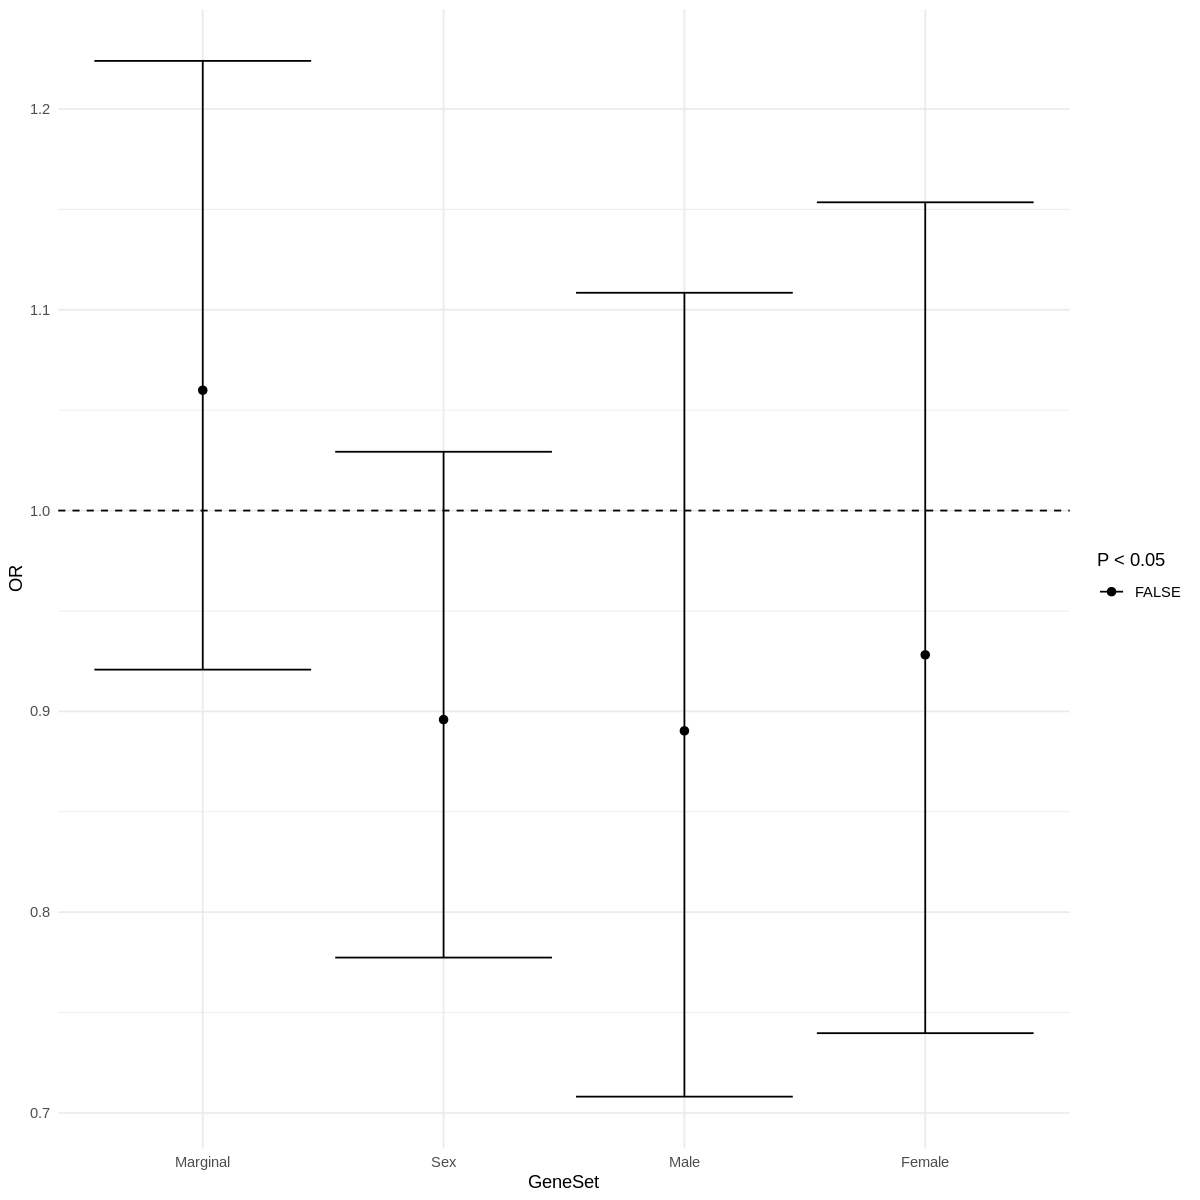

In [13]:
white <- length(hk_genes)
black <- sum(!array_genes %in% hk_genes)

fisher_mat <- function(set1,set2,background){
    notset1 <- background[!background %in% set1]
    notset2 <- background[!background %in% set2]    
    res <- matrix(
        c(
            length(intersect(set1,set2)),
            length(intersect(notset1,set2)),
            length(intersect(set1,notset2)),
            length(intersect(notset1,notset2))
        ),
        byrow=T,
        nrow = 2
    )
    return(res)
}
hk_fisher_res <- function(set){
    res <- fisher.test(fisher_mat(set,hk_genes,array_genes))
    data.table(
        OR = res$estimate,
        low = res$conf.int[1],
        high = res$conf.int[2],
        P = res$p.value
    )
}
res <- rbindlist(lapply(list(Sex=sex_genes,Male=male_genes,Female=female_genes,Marginal=marginal_genes),hk_fisher_res),idcol = 'GeneSet')
res$GeneSet <- factor(res$GeneSet, levels = c("Marginal","Sex","Male","Female"))
ggplot(res,aes(GeneSet,OR,ymin=low,ymax=high,color=P < 0.05)) +
    geom_point(size=2) +
    geom_errorbar(size=0.5) +
    geom_hline(yintercept = 1,linetype='dashed') +
    scale_color_manual(values=c("black", "red")) +
    theme_minimal()
res

### GTEx Gene Set
This set will just take into account the set of genes which have a non-zero median count across all GTEx Tissues

In [8]:
gtex_med_counts <- fread("/scratch/st-dennisjk-1/wcasazza/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz",skip = 2)[Description %in% array_genes]

gtex_fisher_res <- function(set,tpm_thresh){
    select_genes <- gtex_med_counts[apply(gtex_med_counts[,-c(1,2)] > tpm_thresh,1,all)]$Description
    res <- fisher.test(fisher_mat(set,select_genes,array_genes))
    data.table(
        OR = res$estimate,
        low = res$conf.int[1],
        high = res$conf.int[2],
        P = res$p.value,
        TPM_threshold = tpm_thresh
    )
}

GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Marginal,8.469866e-11,1.806463e-06,0.002743552,0.1430070,0.6142715,0.3778809
Sex,1.727210e-08,1.798485e-03,0.077155059,0.7758119,0.8587622,0.7888899
Male,1.052878e-07,1.040409e-03,0.105905736,0.7807035,0.7807787,0.8017267
Female,8.573447e-04,9.199948e-02,0.265557837,0.4663393,0.8332941,0.9326891


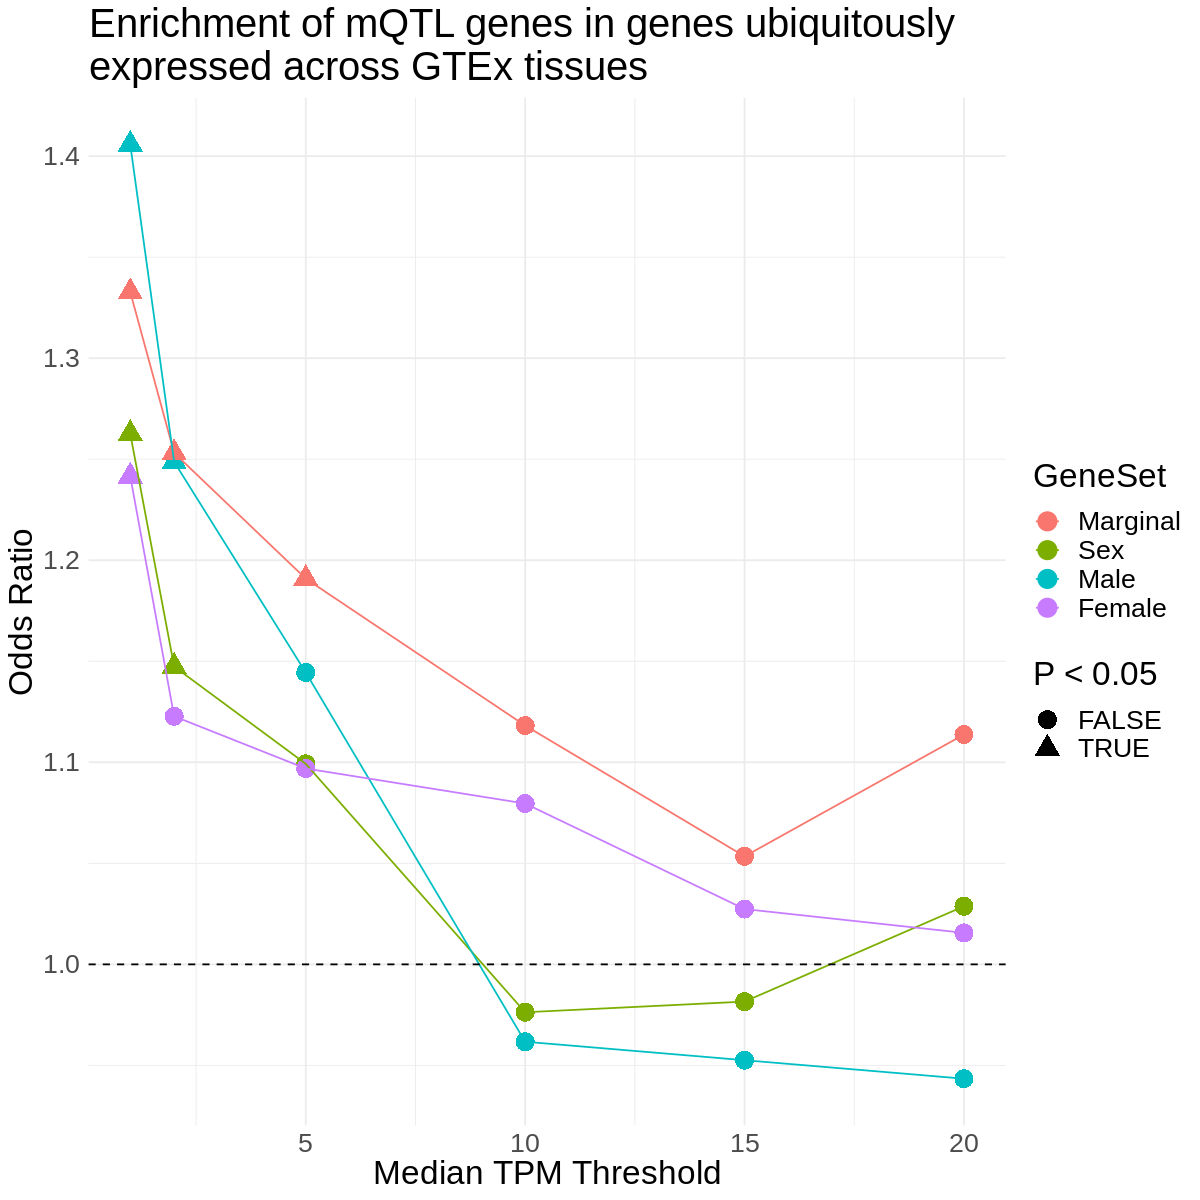

In [7]:
res <- rbindlist(lapply(c(1,2,5,10,15,20),function(thresh)rbindlist(lapply(list(Sex=sex_genes,Male=male_genes,Female=female_genes,Marginal=marginal_genes),function(x)gtex_fisher_res(x,thresh)),idcol = 'GeneSet')))
res$GeneSet <- factor(res$GeneSet, levels = c("Marginal","Sex","Male","Female"))
p <- ggplot(res,aes(TPM_threshold, color=GeneSet)) +
    geom_point(aes(y=OR,shape = P < 0.05),size=5) +
    geom_line(aes(y=OR))+
    geom_hline(yintercept = 1,linetype='dashed') +
    labs(
        title = "Enrichment of mQTL genes in genes ubiquitously\nexpressed across GTEx tissues",
        x = "Median TPM Threshold",
        y = "Odds Ratio"
    )+
    theme_minimal() +
    theme(text=element_text(size=20))
print(p)
dcast(res,GeneSet~TPM_threshold,value.var="P")                                                                           

In [8]:
dcast(res,GeneSet~TPM_threshold,value.var="P")
dcast(res,GeneSet~TPM_threshold,value.var="OR")

GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Marginal,8.469866e-11,1.806463e-06,0.002743552,0.1430070,0.6142715,0.3778809
Sex,1.727210e-08,1.798485e-03,0.077155059,0.7758119,0.8587622,0.7888899
Male,1.052878e-07,1.040409e-03,0.105905736,0.7807035,0.7807787,0.8017267
Female,8.573447e-04,9.199948e-02,0.265557837,0.4663393,0.8332941,0.9326891


GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Marginal,1.332718,1.253090,1.190885,1.1181706,1.0534415,1.1137413
Sex,1.262613,1.147375,1.099234,0.9763010,0.9815828,1.0287538
Male,1.405752,1.248686,1.144431,0.9616962,0.9525556,0.9434084
Female,1.241555,1.122758,1.096920,1.0795858,1.0273550,1.0155746


#  Gene Exploration for Meta-analyzed mQTLs

[1] 136

[1] 635

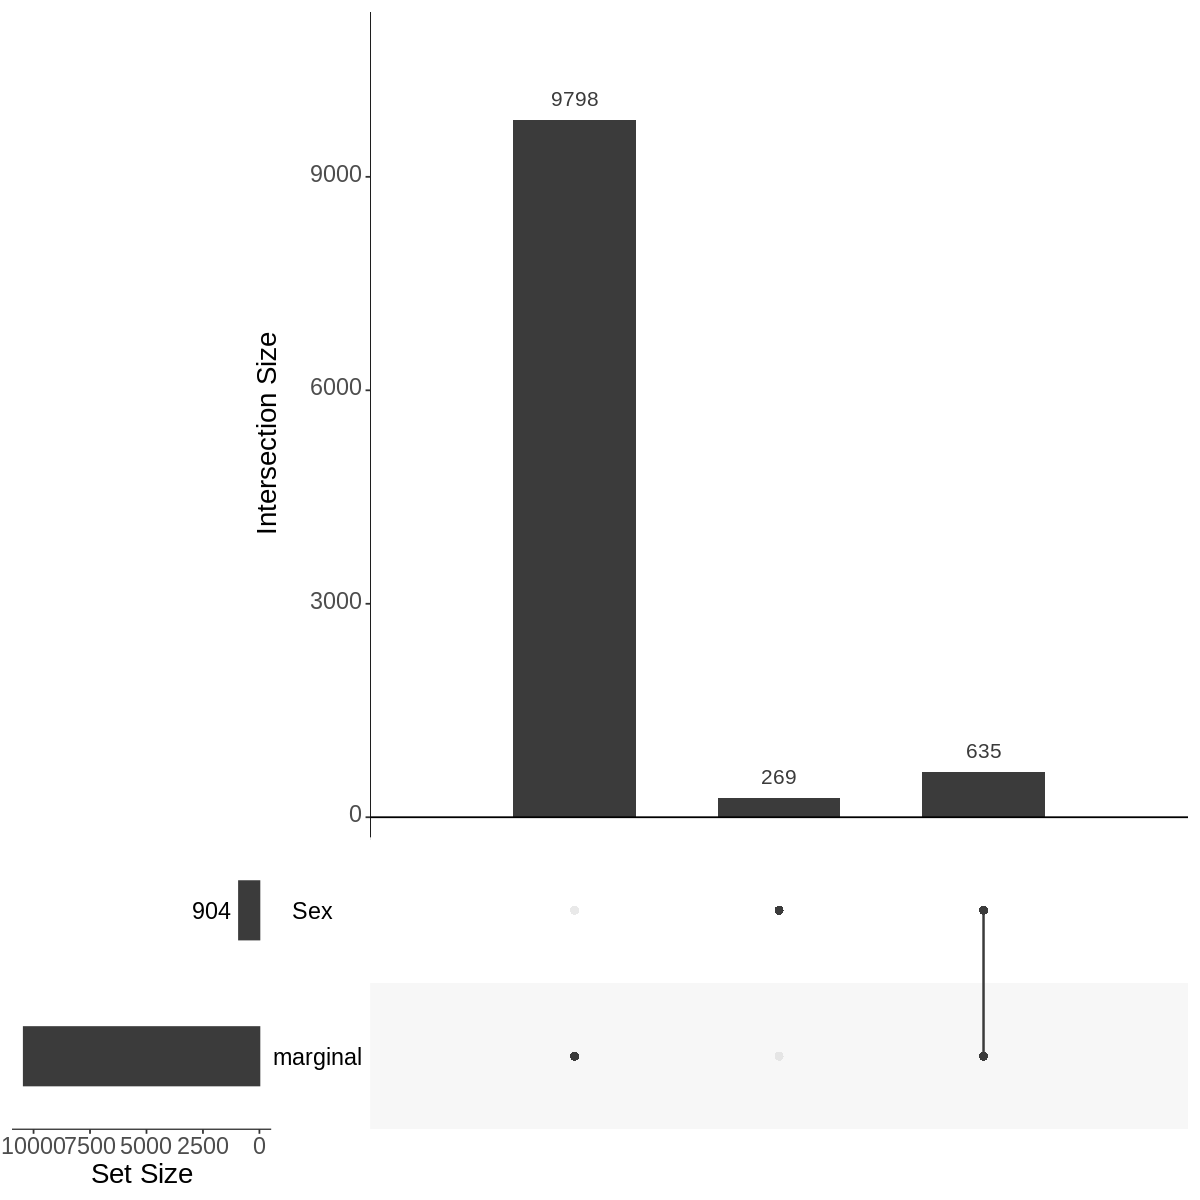

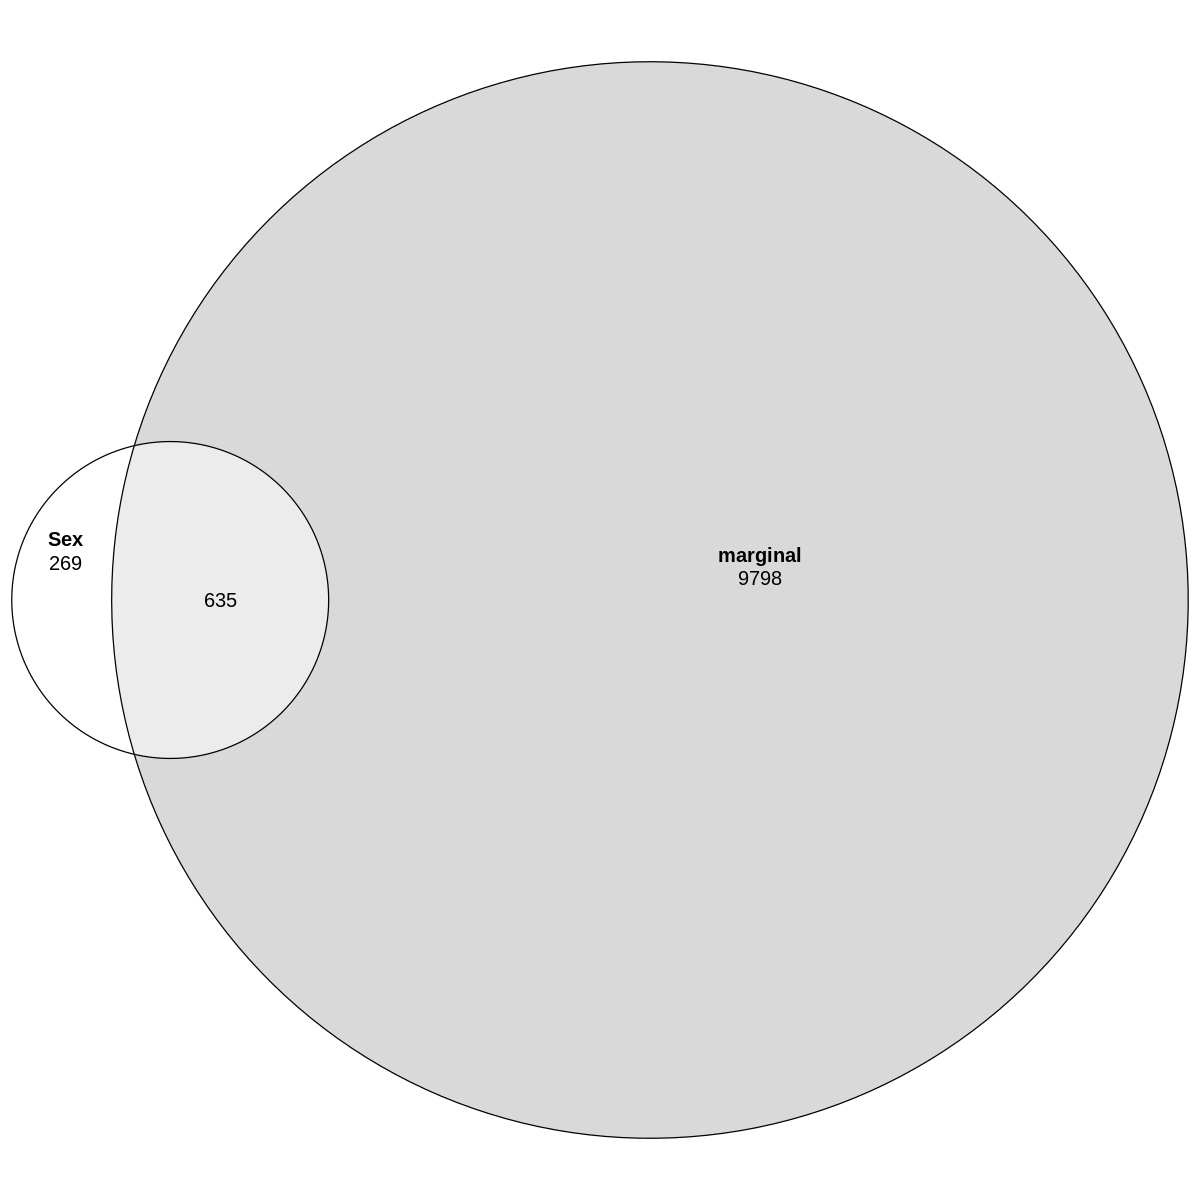

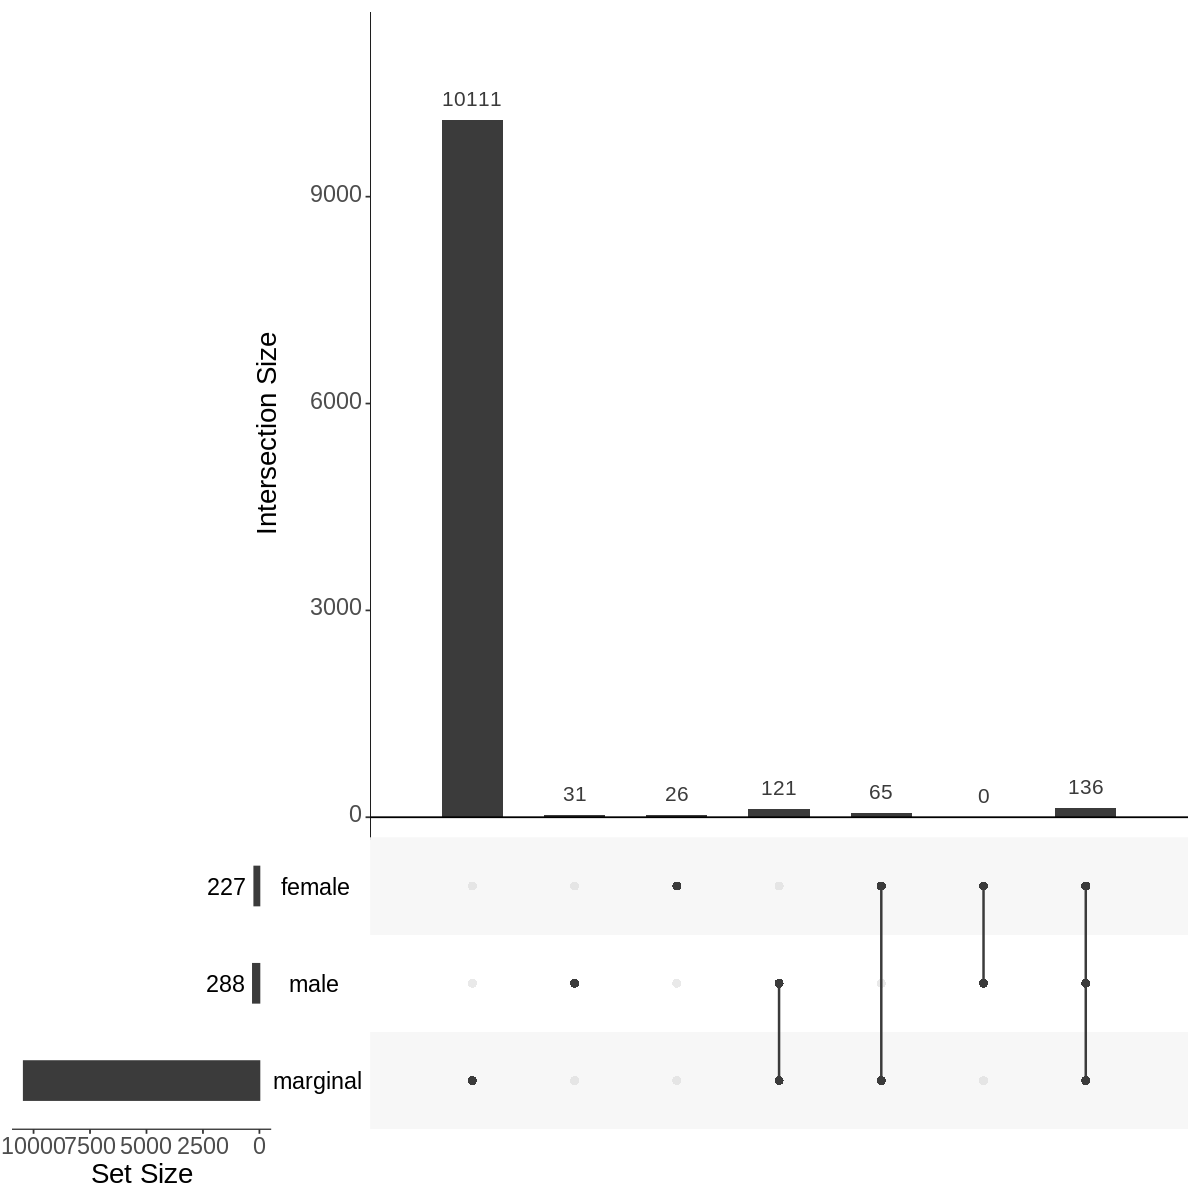

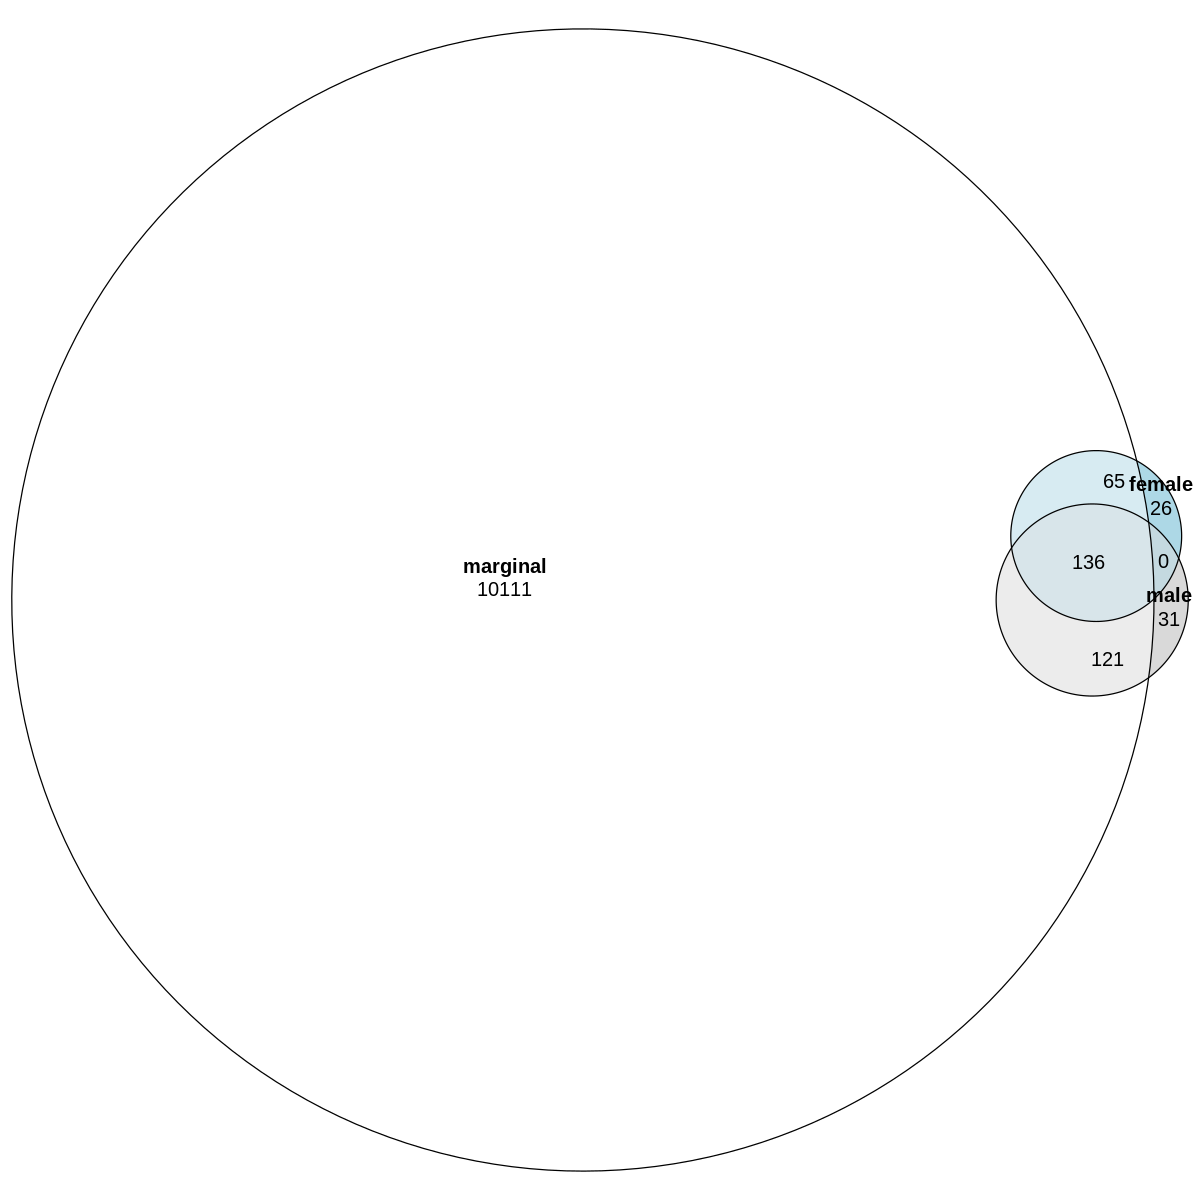

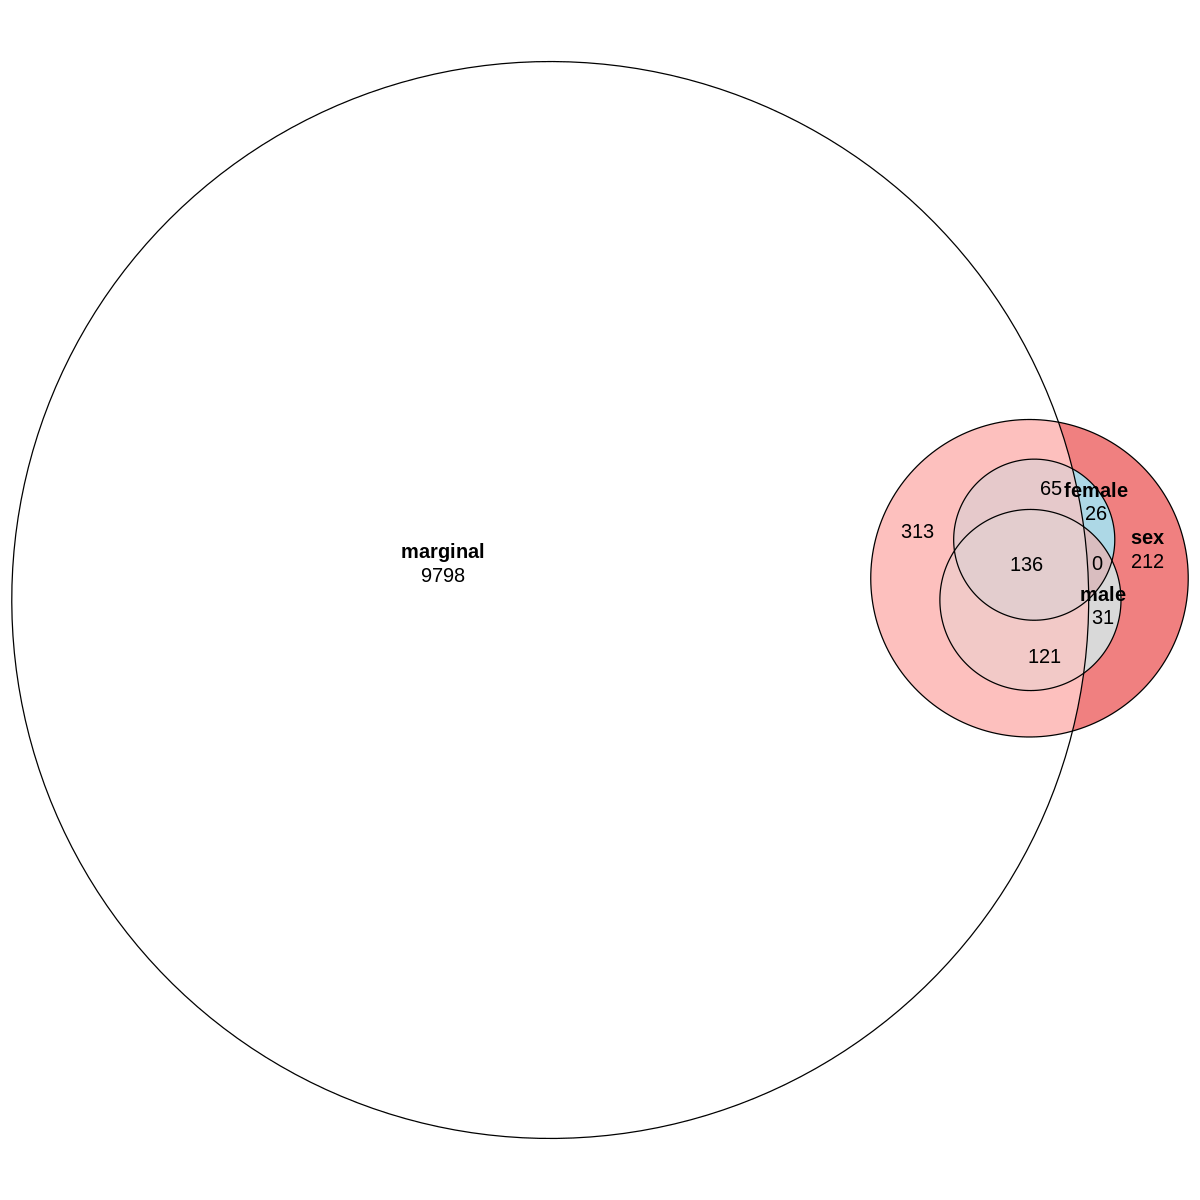

In [19]:
sex_meta <- fread("../data/sex_interaction_meta_annotated_hits.txt.gz")
marginal_meta <- fread("../data/marginal_meta_annotated_hits.txt.gz")
male_meta <- fread("../data/male_meta_annotated_hits.txt.gz")
female_meta <- fread("../data/female_meta_annotated_hits.txt.gz")

sex_thresh <- max(sex_meta$p)
sex_meta_genes <- gsub(";.*","",sex_meta$UCSC_RefGene_Name)
marginal_meta_genes <- gsub(";.*","",marginal_meta$UCSC_RefGene_Name)
male_meta_genes <- gsub(";.*","",male_meta[Probe %in% sex_meta$Probe & p< sex_thresh]$UCSC_RefGene_Name)
female_meta_genes <- gsub(";.*","",female_meta[Probe %in% sex_meta$Probe & p < sex_thresh]$UCSC_RefGene_Name)


sex_meta_genes <- unique(sex_meta_genes[sex_meta_genes != ""])
female_meta_genes <-  unique(female_meta_genes[female_meta_genes != ""])
male_meta_genes <-  unique(male_meta_genes[male_meta_genes != ""])
marginal_meta_genes <-  unique(marginal_meta_genes[marginal_meta_genes != ""])


length(Reduce(function(a,b) intersect(a,b), list(sex_meta_genes,male_meta_genes,female_meta_genes,marginal_meta_genes)))
length(intersect(sex_meta_genes,marginal_meta_genes))
upset_data <- fromList(list(Sex=sex_meta_genes, marginal=marginal_meta_genes))    
upset(upset_data, group.by=c("degree"), empty.intersections="on", set_size.show = TRUE,text.scale = 2)
plot(euler(upset_data),quantities=TRUE)

upset_data_sex <- fromList(list(marginal= marginal_meta_genes,male=male_meta_genes,female=female_meta_genes))
upset(upset_data_sex, group.by=c('degree'), empty.intersections="on", set_size.show = TRUE,text.scale=2)
plot(euler(upset_data_sex),quantities=TRUE)

upset_data_all <- fromList(list(marginal= marginal_meta_genes,male=male_meta_genes,female=female_meta_genes,sex=sex_meta_genes))
plot(euler(upset_data_all),quantities=TRUE)

GeneSet,1,2,5,10,15,20
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Marginal,0.1872595284,0.151286740,0.004867753,1.290406e-05,0.0000221922,2.225586e-05
Sex,0.0006671913,0.007639452,0.163616373,7.153627e-01,0.4936131738,1.000000e+00
Male,0.5743173761,0.595674172,1.000000000,8.318627e-01,0.5054804900,3.762756e-02
Female,0.8885180517,1.000000000,0.466532561,9.047454e-01,0.6552406738,3.658546e-01


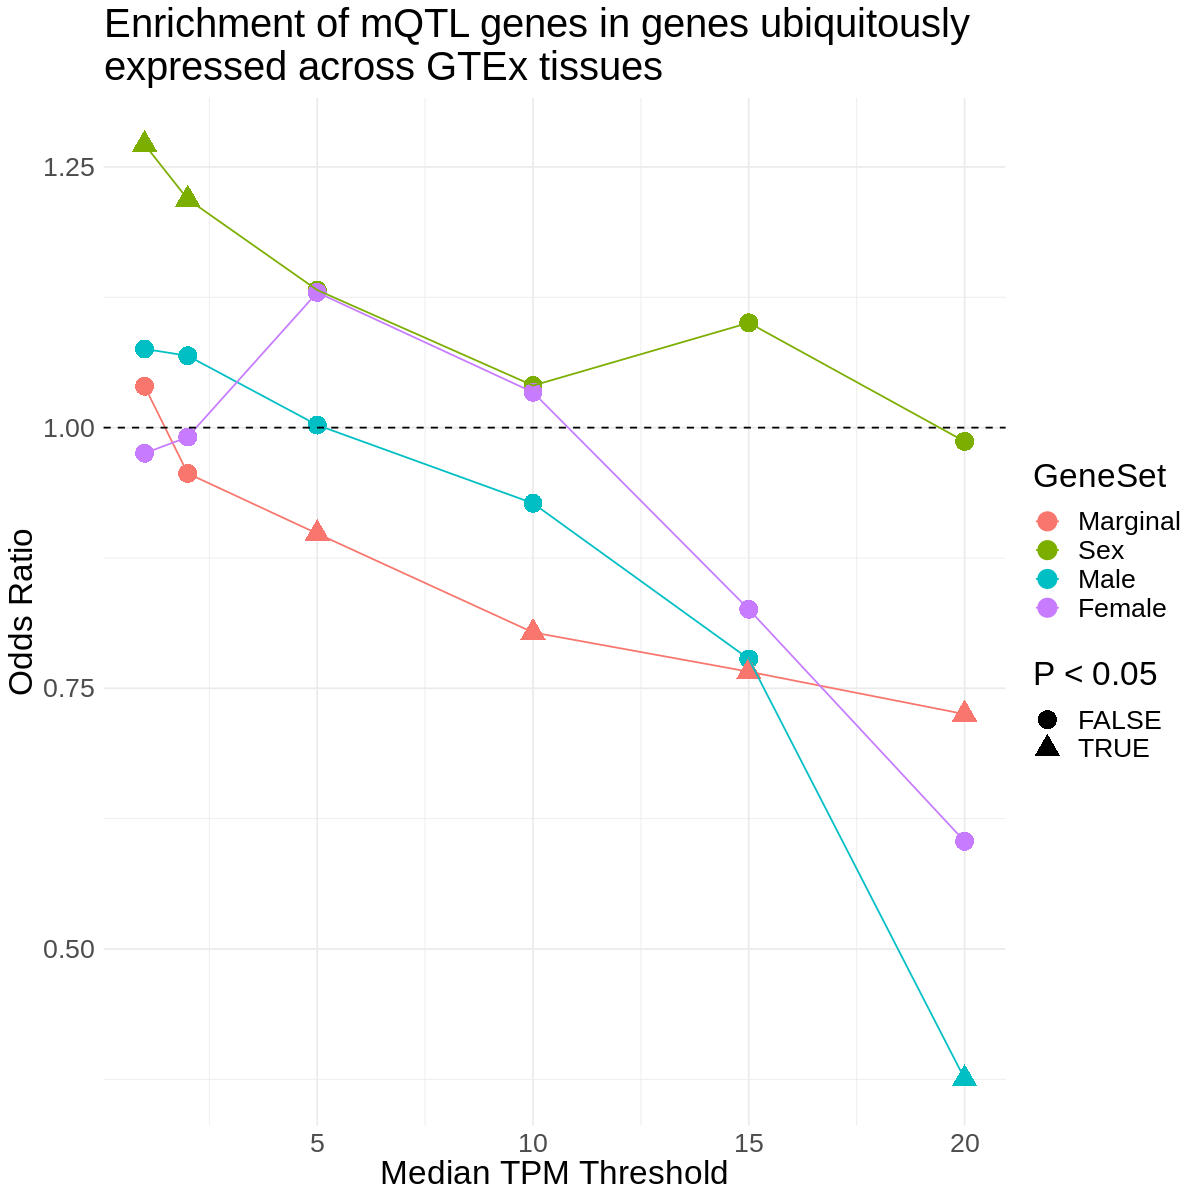

In [20]:
res <- rbindlist(lapply(c(1,2,5,10,15,20),function(thresh)rbindlist(lapply(list(Sex=sex_meta_genes,Male=male_meta_genes,Female=female_meta_genes,Marginal=marginal_meta_genes),function(x)gtex_fisher_res(x,thresh)),idcol = 'GeneSet')))
res$GeneSet <- factor(res$GeneSet, levels = c("Marginal","Sex","Male","Female"))
dcast(res,GeneSet~TPM_threshold,value.var="P")
p <- ggplot(res,aes(TPM_threshold, color=GeneSet)) +
    geom_point(aes(y=OR,shape = P < 0.05),size=5) +
    geom_line(aes(y=OR))+
    geom_hline(yintercept = 1,linetype='dashed') +
    labs(
        title = "Enrichment of mQTL genes in genes ubiquitously\nexpressed across GTEx tissues",
        x = "Median TPM Threshold",
        y = "Odds Ratio"
    )+
    theme_minimal() +
    theme(text=element_text(size=20))
print(p)

GeneSet,OR,low,high,P
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Sex,1.0223357,0.8057657,1.2836485,8.162404e-01
Male,0.8703168,0.5463384,1.3277109,6.114146e-01
Female,1.3545827,0.8751987,2.0250605,1.373473e-01
Marginal,0.8019926,0.7293771,0.8816818,3.788655e-06


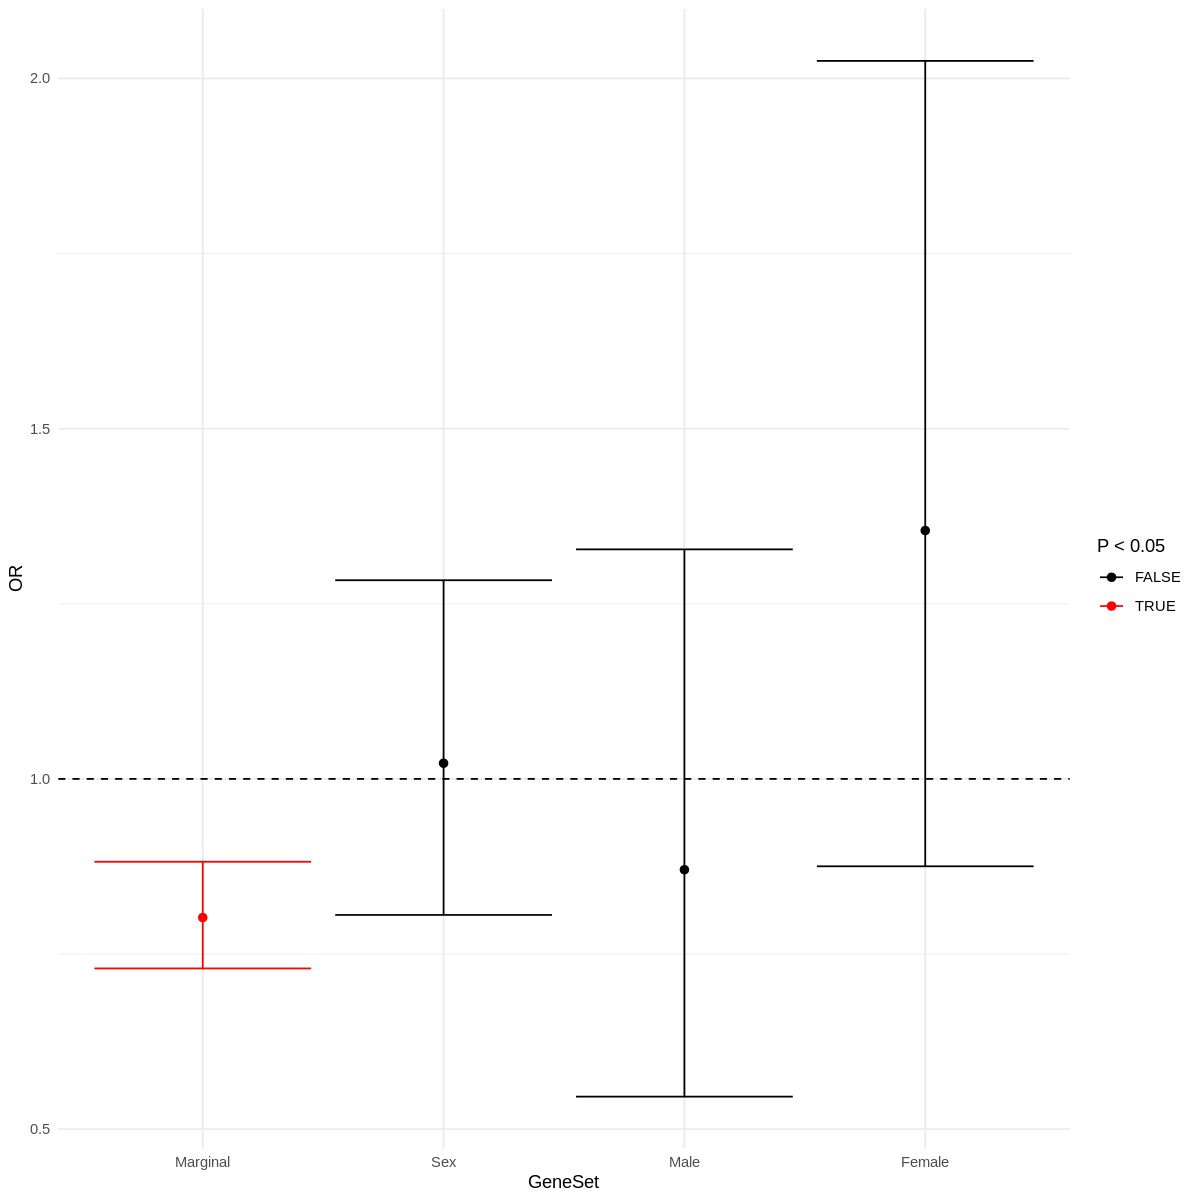

In [22]:
res <- rbindlist(lapply(list(Sex=sex_meta_genes,Male=male_meta_genes,Female=female_meta_genes,Marginal=marginal_meta_genes),hk_fisher_res),idcol = 'GeneSet')
res$GeneSet <- factor(res$GeneSet, levels = c("Marginal","Sex","Male","Female"))
ggplot(res,aes(GeneSet,OR,ymin=low,ymax=high,color=P < 0.05)) +
    geom_point(size=2) +
    geom_errorbar(size=0.5) +
    geom_hline(yintercept = 1,linetype='dashed') +
    scale_color_manual(values=c("black", "red")) +
    theme_minimal()
res

## Last check Venn Diagram for cpgs in delahaye data

In [14]:
library(VennDiagram)
maf_05 <- fread("../data/delahaye_snps_maf05.csv",header=T)
sex_interaction <- fread("../../delahaye_QC/delahaye_stratified_regression_fdr_hits.txt")
head(sex_interaction)
head(maf_05)
venn.diagram(
  x = list(
        unique(sex_interaction[SNP %in% maf_05$SNP & res_m < max(`p-value`)]$gene),
        unique(sex_interaction[SNP %in% maf_05$SNP & res_f < max(`p-value`)]$gene)
    ),
  category.names = c("Unique Effect in Males","Unique Effect in Females"),
  filename = 'cpg_overlap_delahaye_male_female.png',
  output = TRUE ,
          imagetype="png" ,
          height = 480 ,
          width = 480 ,
          resolution = 300,
          compression = "lzw",
          lwd = 1,
          col=c("#eea2adff", '#8b5f65ff'),
          fill = c(alpha("#eea2adff",0.3), alpha('#8b5f65ff',0.3)),
          cex = 0.5,
          fontfamily = "sans",
          cat.cex = 0.3,
          cat.default.pos = "outer",
          cat.pos = c(-27, 27),
          cat.dist = c(0.055, 0.055),
          cat.fontfamily = "sans"
  #         cat.col = c("#440154ff", '#21908dff'),
  #         rotation = 1
        )

SNP,gene,beta,t-stat,p-value,FDR,res_m,beta_m,se_m,aFC_m,res_f,beta_f,se_f,aFC_f
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs114260927,cg23406642,-663.1006091,-135.82145,7.378496e-240,2.478188e-231,3.817019e-02,0.005485140,0.002619220,0.01353609,7.304164e-122,660.534752978,4.933714980,1.00051883
rs138599061,cg18678211,-1.9976063,-111.42949,2.665557e-218,4.476353e-210,4.339435e-01,0.004001479,0.005098233,0.01410621,2.073713e-111,1.995736707,0.018659484,1.20565172
rs148672898,cg18678211,-0.6137418,-85.81615,3.930624e-190,2.640328e-182,2.840452e-01,-0.005516612,0.005128463,-0.01856809,2.073713e-111,0.603315801,0.005640805,2.44932793
rs186399103,cg18678211,-0.6137418,-85.81615,3.930624e-190,2.640328e-182,2.840452e-01,-0.005516612,0.005128463,-0.01856809,2.073713e-111,0.603315801,0.005640805,2.44932793
rs141188797,cg18678211,-0.6137418,-85.81615,3.930624e-190,2.640328e-182,2.840452e-01,-0.005516612,0.005128463,-0.01856809,2.073713e-111,0.603315801,0.005640805,2.44932793
rs565953286,cg20947866,5.3615974,81.65367,8.092711e-185,4.530114e-177,9.994351e-119,5.368322613,0.060652379,1.06559221,2.841061e-01,-0.009930923,0.009225265,-0.01801896


V1,SNP
<int>,<chr>
110,rs61768207
521,rs76723341
705,rs144694530
711,rs7419177
772,rs2340594
777,rs28536514


[1] 1